<h1>Image Captions Predicting</h1>

In this mini-project I'll take an image and their possible captions from the Flickr8k library and predict captions on images.<br>
First, I'll clean the raw data captions, and create a unique vocabulry of possible words.<br>
The train data will be the images and their captions, and the testing data wll be only the images.<br>
For the image preprocess I'll use ResNet50- a model to extract features from the train images, and than encode the images to one numerical vector.<br> 
For the caption preprocess, I'll create a mapping between the encoded vetor to its translation into a sequence of words, and then use word embeddings- convert each word to a vector using the GloVe algorithm.<br>
The unique words will be loaded to the predictiong model in a form of an embedding matrix.<br>

After all that, I'll create a predictive model with 2 parts- image and caption, that will be able to predict a probability for each word suggested to be in the caption for the image.<br>
To sum it up, I'll evaluate my model with the BLEU score- an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another, with different weights (1-gram, 2-gram, 3-gram and 4-gram).<br>
<br>
For example:

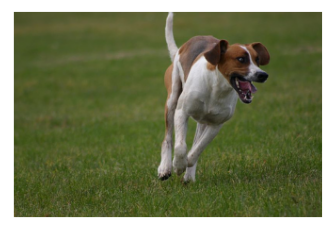

In [10]:
plt.imread("insert here relevant example image")
plt.imshow(i)
plt.axis("off")
plt.show()

<u>The different BLEU scores are:</u><br>
Cumulative 1-gram: 1.000<br>
Cumulative 2-gram: 1.000<br>
Cumulative 3-gram: 0.957<br>
Cumulative 4-gram: 0.889<br>
<u>The actual caption was:</u> a brown and white dog runs across the grass <br>
<u>The prediction was:</u> a brown and white dog is running through the grass

<h3>IMPORT DATA</h3>

importing libraries

In [2]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import string
import warnings
warnings.filterwarnings("ignore")

from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from time import time
import pickle as pkl #Pickle module is a popular format used to serialize and deserialize data types

import tensorflow as tf
import matplotlib.pyplot as plt
import nltk #for BLEU evaluation score

data sources

In [3]:
folder='insert here relevant folder'
raw_data='insert here raw data file'
train_imgs='insert here train file'
test_imgs='insert here test file'
images='insert here image_dataset'
glove_txt='insert here custom GloVe link'
model_save='insert here model export link'

creating a dictionary from the raw data where- <br>
- the keys are the name of the picture<br>
- the values are the picture's description

In [4]:
def txt_to_dict(data_src):
    df=pd.read_csv(data_src, sep='\t', header=None, names=['figure', 'description'])
    df[['figure', 'pic#','drop']]=df.figure.str.split(".", expand=True)
    df=df.drop(columns=['drop', 'pic#']).set_index('figure')
    dict_=defaultdict(list)
    for index,row in df.iterrows():
        dict_[index].append(row['description'])
    
    return dict_

In [5]:
raw_data_dict=txt_to_dict(raw_data)

Example:

In [6]:
raw_data_dict['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

<h3>CLEAN DATA</h3><br>
1. convert to lowercase characters <br>
2. clean punctuations<br>
3. clean special characters<br>
4. clean extra spaces<br>

In [7]:
def clean_text(st):
    st=st.lower() #lower case
    st=st.translate(str.maketrans('', '', string.punctuation)) #clean puctuations, clean special characters
    st=" ".join(st.split()) #clean extra spaces
    return st

In [8]:
final_data_dict=defaultdict(list)
for key,val in raw_data_dict.items():
    val1=list()
    for i in range(len(val)):
        val1.append(clean_text(val[i]))
    final_data_dict[key]=val1 

In [9]:
final_data_dict['1000268201_693b08cb0e']

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

<h3>CREATE A VOCABULARY FROM EACH IMAGE</h3>

In [10]:
# unique vocabulary
vocab=set()
[[vocab.update(st.split()) for st in final_data_dict[key]] for key in final_data_dict.keys()]

# vocabulary with all words 
all_vocab=list()
[[all_vocab.append(i) for st in final_data_dict[key] for i in st.split()] for key in final_data_dict.keys()]

# count frequency of words and remove words with frequency<=10- to remove outliers
cnt=dict(Counter(all_vocab))
all_vocab_frequency=sorted(cnt.items(), reverse=True, key=lambda x: x[1])
all_vocab_frequency=[word for word in all_vocab_frequency if word[1]>10]
all_vocab=[word[0] for word in all_vocab_frequency]

In [11]:
len(all_vocab)

1847

<h3>TRAIN & TEST DATA</H3>

In [12]:
file1=open(train_imgs)
file2=open(test_imgs)

train_data=file1.read()
test_data=file2.read()

file1.close()
file2.close()

# keeping image names only- without .jpg and dividing them to strings by \n
train_data=[val.split('.')[0] for val in train_data.split('\n')[:-1]]
test_data=[val.split('.')[0] for val in test_data.split('\n')[:-1]]

In [13]:
# create train dictionary- all values will be with "startseq" and "endseq"
train_dict=defaultdict(list)
for img in train_data:
    for val in final_data_dict[img]:
        val_add="startseq "+val+" endseq"
        train_dict[img].append(val_add)

In [14]:
train_dict['2513260012_03d33305cf']

['startseq a black dog is running after a white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through a low lying body of water endseq']

<h3>DATA PREPROCESS</h3><br>
I'll use the ResNet50 model to extract features from the train images. <br>
ResNet50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer).<br><br>
The ResNet architecture follows two basic design rules:<br>
- First, the number of filters in each layer is the same depending on the size of the output feature map <br>
- Second, if the feature map’s size is halved, it has double the number of filters to maintain the time complexity of each layer.<br><br>

I'll need to use only 49 layers- since the last layer is used for classification 

In [15]:
tmp_model=ResNet50(weights="imagenet", input_shape=(224,224,3))
model=Model(tmp_model.input, tmp_model.layers[-2].output) #removimg the last layer from the ResNet50 model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

<h4>Preprocess Images</h4>

In [16]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [ ]:
start = time()

encoding_train = {}

for ix, img in enumerate(train_data):
    
    img = images+r"\{}.jpg".format(train_data[ix])
    encoding_train[img[len(images)+1:-4]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

In [ ]:
start = time()

encoding_test = {}

for ix, img in enumerate(test_data):
    
    img = images+r"\{}.jpg".format(train_data[ix])
    encoding_test[img[len(images)+1:-4]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

In [19]:
#serialize the encoded train and test data so we won't need to run it everytime
with open(folder+r"\encoded_train_images.pkl", "wb") as encoded_pickle:
    pkl.dump(encoding_train, encoded_pickle)

with open(folder+r"\encoded_test_images.pkl", "wb") as encoded_pickle:
    pkl.dump(encoding_test, encoded_pickle)

In [20]:
#load the pickle file we already ran
with open(folder+r"\encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pkl.load(encoded_pickle)

with open(folder+r"\encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pkl.load(encoded_pickle)

<h4>Preprocess Captions</h4>

In [21]:
# creating a dictionary to map words into indexes and vice versa
# so the ML model will get only numbers and the prediction will be also just numbers
index=1
word_to_index=dict()
index_to_word=dict()

for word in all_vocab:
    word_to_index[word]=index
    index_to_word[index]=word
    index+=1

word_to_index['startseq']=len(index_to_word)+1
word_to_index['endseq']=len(index_to_word)+2

index_to_word[len(word_to_index)]='endseq'
index_to_word[len(word_to_index)-1]='startseq'

vocab_size=len(index_to_word)+1 #vocabulary size +1
all_captions_len=list()

for key,val in train_dict.items():
    for sentence in val:         
        all_captions_len.append(len(sentence.split()))
max_len=max(all_captions_len) #max length of an image caption

Since the dataset is very large, I'll build a generator function to feed the model in batches.<br>
I'll give the image vector and the first word (startseq), the model will predict the next word, and add the prediction to the sequence.<br>
It'll keep going until the sequence will get to the max length or the end of the sequence (endseq)

In [22]:
def data_generator(train_dict, encoding_train, word_to_index, max_len, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while True:
        for key, desc_list in train_dict.items():
            n +=1
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_index[word] for word in desc.split() if word in word_to_index]  
                for i in range(1,len(seq)):
                    in_seq = seq[0:i]
                    out_seq = seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                u = np.array(X1)
                v = np.array(X2)
                w = np.array(y)
                yield ([u,v],w)
                X1, X2, y = list(), list(), list()
                n=0

I'm going to use <b>word embeddings</b>- so I'm going to convert each word to a vector using <b>GloVe algorithm</b>.<br>
GloVe is an unsupervised learning algorithm for obtaining vector representations for words.<br>
Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [23]:
glove=open(glove_txt, encoding='utf8')

embedding_index = dict()

for line in glove:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
glove.close()

All the unique words in the vocabulary will get an embedding matrix which will be loaded to the model (since I cannot feed the data directly).

In [24]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_index.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

We'll get an output in shape of (vocabulary size, embedding dimensions)

In [25]:
embedding_output.shape

(1850, 50)

<h3>CREATING THE MODEL</h3>

I'll create a model in 2 parts-
- images
- partial captions

I'll use APIs from the keras library, so I will be able to merge models

In [26]:
# image feature extractor model
input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea) # in order to avoid overfitting
inp_img2 = Dense(256, activation='relu')(inp_img1)

# partial caption sequence model
input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1) #avoid overfitting
inp_cap3 = LSTM(256)(inp_cap2) #help maximizing performances

decoder1 = Add()([inp_img2,inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

This model will be able to predict the probabilities for each word- then I'll choose the word with the max probability and add it to the sequence

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 38)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 38, 50)               92500     ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

Now, I'll add the embedding matrix layer, and freeze it before the training- so it won't get updated during the back propagation process.<br>
Finally- the model will update its weights until the back propagation and the model will learn how to output a word when we give it an image and a partial caption.<br>


In [28]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False #freeze layer- it won't be updated during training
model.compile(loss="categorical_crossentropy", optimizer="adam")

<h3>MODEL TRAINING</h3>

In [29]:
number_pics_per_batch = 20
steps = len(train_dict)//number_pics_per_batch

generator = data_generator(train_dict, encoding_train, word_to_index, max_len, number_pics_per_batch)
model.fit_generator(generator, epochs=20, steps_per_epoch=steps, verbose=1)
model.save(model_save + str(i) + '.h5')

tf.config.experimental_run_functions_eagerly(True)

Epoch 1/20
300/300 [==============================] - 1331s 4s/step - loss: 4.2939
Epoch 2/20
300/300 [==============================] - 1310s 4s/step - loss: 3.4260
Epoch 3/20
300/300 [==============================] - 1319s 4s/step - loss: 3.1598
Epoch 4/20
300/300 [==============================] - 1277s 4s/step - loss: 2.9931
Epoch 5/20
300/300 [==============================] - 1253s 4s/step - loss: 2.8723
Epoch 6/20
300/300 [==============================] - 1285s 4s/step - loss: 2.7771
Epoch 7/20
300/300 [==============================] - 1352s 5s/step - loss: 2.6974
Epoch 8/20
300/300 [==============================] - 1435s 5s/step - loss: 2.6340
Epoch 9/20
300/300 [==============================] - 1342s 4s/step - loss: 2.5798
Epoch 10/20
300/300 [==============================] - 1247s 4s/step - loss: 2.5295
Epoch 11/20
300/300 [==============================] - 1272s 4s/step - loss: 2.4895
Epoch 12/20
300/300 [==============================] - 1402s 5s/step - loss: 2.4540
E

<h3>MODEL PREDICTION</h3>

Creating a function that will get a photo and predict its caption- based on the model above

In [32]:
def predict_sequence(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        #same sequence length for uniformity- there are sequences with different length- every sequnce will be the max_len
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post') 

        ypred =  model.predict([photo,sequence]) #will predict probability of every index in the vocabulary
        ypred = ypred.argmax() #choose the max probability
        word = index_to_word[ypred] #convert from index to word
        in_text+= ' ' +word #add predicted word to the sequence
        
        if word =='endseq':
            break
        
        
    final_sequence =  in_text.split()
    final_sequence = final_sequence[1:-1] #remove 'startseq' and 'endseq' from the final caption prediction 
    final_sequence = ' '.join(final_sequence)
    
    return final_sequence

Testing the model-<br>
I'll choose 20 photos randomly and predict their sequences

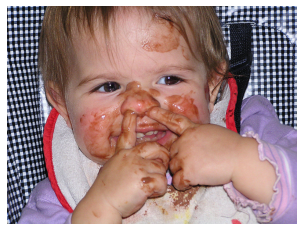

1/1 [==============================] - 0s 116ms/step
a baby with fingers fingers up fingers nose up


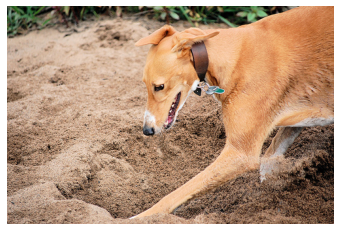

1/1 [==============================] - 0s 119ms/step
a dog is running on the sand with a tennis ball in its mouth


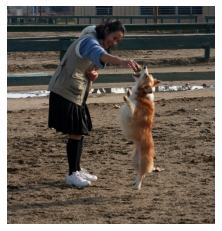

1/1 [==============================] - 0s 99ms/step
a dog is running on the grass with a tennis ball in its mouth


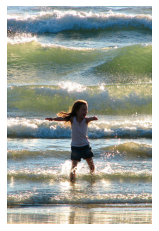

1/1 [==============================] - 0s 109ms/step
a girl in a swimsuit is running through the water


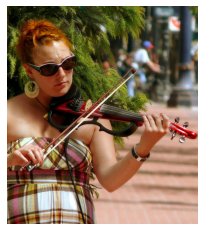

1/1 [==============================] - 0s 172ms/step
a woman in a red shirt and gold shirt plays on the street


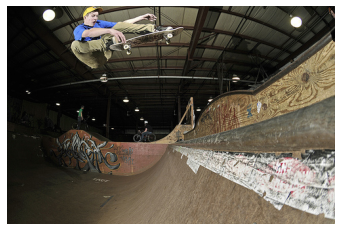

1/1 [==============================] - 0s 129ms/step
a skateboarder is doing a trick on a ramp


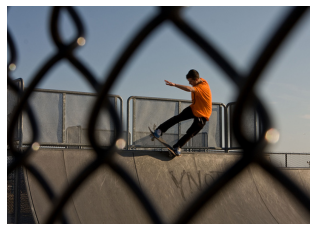

1/1 [==============================] - 0s 105ms/step
a skateboarder is on a ramp


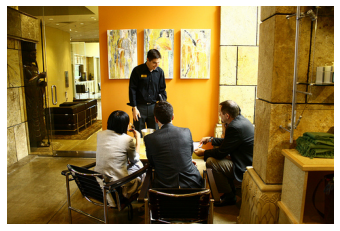

1/1 [==============================] - 0s 120ms/step
a man and woman sit on a desk with a


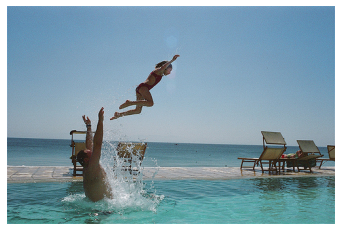

1/1 [==============================] - 0s 149ms/step
a man jumps into the pool at the ocean


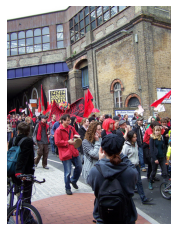

1/1 [==============================] - 0s 173ms/step
a crowd of people are standing in front of a building


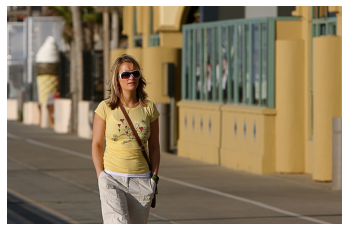

1/1 [==============================] - 0s 99ms/step
a woman in a yellow shirt and a black shirt is standing on a cellphone


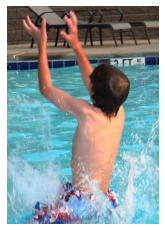

1/1 [==============================] - 0s 101ms/step
a boy in a pool suit is jumping into a swimming pool


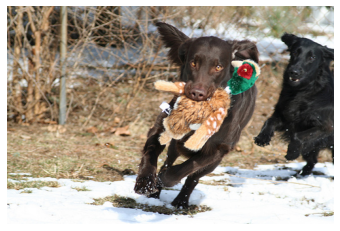

1/1 [==============================] - 0s 102ms/step
two dogs are playing in the snow


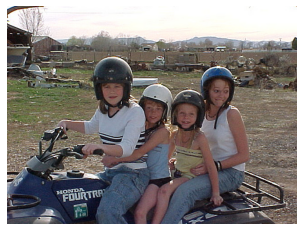

1/1 [==============================] - 0s 113ms/step
a photographer and woman sit on a bench in front of a large building


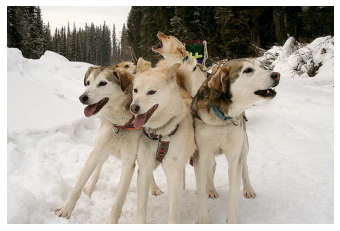

1/1 [==============================] - 0s 104ms/step
a group of dogs are running in the snow


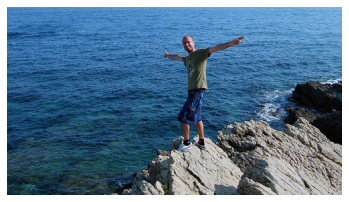

1/1 [==============================] - 0s 125ms/step
a man in a swimsuit suit is standing on a rocky ledge


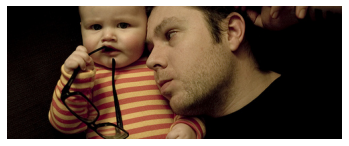

1/1 [==============================] - 0s 98ms/step
a man with glasses glasses his hair


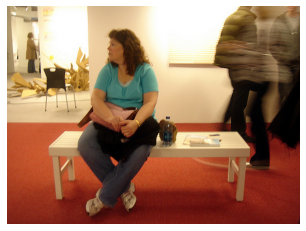

1/1 [==============================] - 0s 97ms/step
a woman in a red shirt is sitting on a couch


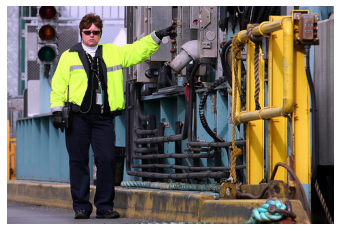

1/1 [==============================] - 0s 115ms/step
a woman in a red shirt is sitting on a bench with a colorful bag


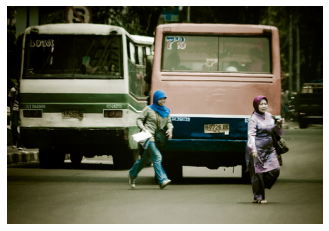

1/1 [==============================] - 0s 95ms/step
two women in blue shirts are sitting on a bus stop


In [33]:
for i in range(20):
    rand_num =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rand_num]
    photo = encoding_test[img_name].reshape((1,2048)) #taking the photo from the test batch

    i = plt.imread(images+"\\"+img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    sequence = predict_sequence(photo)
    
    print(sequence)

<h3>EVALUATION METRICS</h3>

I'll use <b>BLEU (BiLingual Evaluation Understudy)</b>- an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another.<br>
The BLEU score is a number between 0 and 1 that measures the similarity of the machine-translated text to a set of high quality reference translations.

In [37]:
reference

'two women with their heads covered crossing the road in front of buses'

In [38]:
hypothesis

'two women in blue shirts are sitting on a bus stop'

In [35]:
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

0.3788517106144227


In [36]:
for i in range(5):
    reference=final_data_dict[img_name][i] 
    hypothesis=sequence
    BLEUscore += nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore/5)

0.4614060792307835


calculating BLEU score with weights- <b>n-gram score</b><br>
The words will be matched to each other-
- 1-gram: one at a time, with weights (1,0,0,0)- want a perfect match to the reference
- 2-gram: 2 at a time, with weights (0.5,0.5,0,0)
- 3-gram: 3 at a time, with weights (0.33,0.33,0.33,0)
- 4-gram: 4 at a time, with weights (10.25,0.25,0.25,0.25)

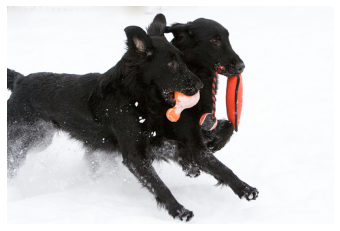

1/1 [==============================] - 0s 151ms/step
Cumulative 1-gram:0.833
Cumulative 2-gram:0.707
Cumulative 3-gram:0.503
Cumulative 4-gram:0.000
two black dogs fetching toys in the snow
two dogs play in the snow


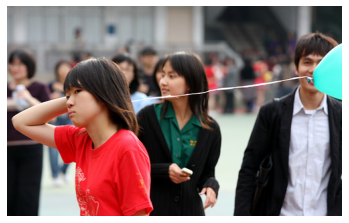

1/1 [==============================] - 0s 158ms/step
Cumulative 1-gram:0.444
Cumulative 2-gram:0.333
Cumulative 3-gram:0.000
Cumulative 4-gram:0.000
a girl holds a blue balloon as she walks
a crowd of people are talking on a cellphone


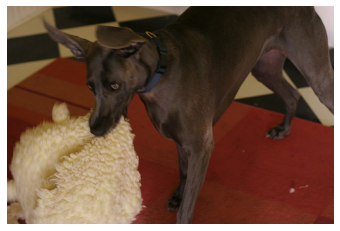

1/1 [==============================] - 0s 153ms/step
Cumulative 1-gram:0.875
Cumulative 2-gram:0.866
Cumulative 3-gram:0.723
Cumulative 4-gram:0.622
a brown dog is chewing on a white rug whilst standing on a red carpet next to a checkered floor
a dog is playing with a red toy
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\shdekel\Anaconda3\lib\site-packages\keras\src\backend.py", line 5119, in <genexpr>
    ta.write(ta_index_to_write, out)  File "C:\Users\shdekel\Anaconda3\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


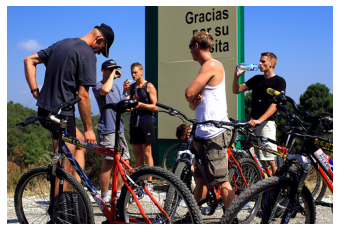

1/1 [==============================] - 0s 139ms/step
Cumulative 1-gram:0.615
Cumulative 2-gram:0.392
Cumulative 3-gram:0.307
Cumulative 4-gram:0.230
a group of bicyclists getting ready for a ride
a group of men with bicycles are riding bicycles on a sunny day


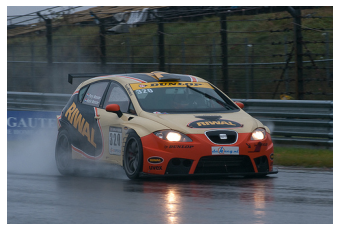

1/1 [==============================] - 0s 160ms/step
Cumulative 1-gram:0.651
Cumulative 2-gram:0.595
Cumulative 3-gram:0.453
Cumulative 4-gram:0.350
a car sponsored by riwal is smoking its tires on a wet road
a race car drives around a track


In [44]:
for i in range(5):
    rand_num =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rand_num]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+"\\"+img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    sequence = predict_sequence(photo)
    
    BLEUscore=0
    ref1=final_data_dict[img_name][0].split()
    ref2=final_data_dict[img_name][1].split() 
    ref3=final_data_dict[img_name][2].split() 
    ref4=final_data_dict[img_name][3].split() 
    ref5=final_data_dict[img_name][4].split() 
    ref_list=[[ref1, ref2, ref3, ref4, ref5]]
    hypothesis=sequence.split()
    
    BLEUscore1 = nltk.translate.bleu_score.corpus_bleu(ref_list, [hypothesis], weights=(1, 0, 0, 0))
    BLEUscore2 = nltk.translate.bleu_score.corpus_bleu(ref_list, [hypothesis], weights=(0.5, 0.5, 0, 0))
    BLEUscore3 = nltk.translate.bleu_score.corpus_bleu(ref_list, [hypothesis], weights=(0.33, 0.33, 0.33, 0))
    BLEUscore4 = nltk.translate.bleu_score.corpus_bleu(ref_list, [hypothesis], weights=(0.25, 0.25, 0.25, 0.25))
    
    print("Cumulative 1-gram:%.3f"%BLEUscore1) 
    print("Cumulative 2-gram:%.3f"%(BLEUscore2))
    print("Cumulative 3-gram:%.3f"%(BLEUscore3))
    print("Cumulative 4-gram:%.3f"%(BLEUscore4))
    print(final_data_dict[img_name][0]) #actual caption
    print(sequence) #prediction